# Análisis de Redes Sociales, Práctica I
Paula Corral rebollar y Lucía Cuevas Serrano

# Datos

In [1]:
#!pip install grakel --quiet
#!pip uninstall -y numpy --quiet
#!pip install numpy==1.26.4 --quiet

# Ejecutar esta celda, comentarla y reiniciar el kernel si se una Colab

## Cargar datos

Cargamos los datos directamente del archivo en github y lo abrimos como un grafo usando NetworkX.

In [88]:
import requests
import networkx as nx
from io import BytesIO
import numpy as np

# Descargar archivo
response = requests.get("https://raw.githubusercontent.com/luciacuevascsv/analisis_redes_sociales/main/Practica%20I/hashtags_cleaned.graphml")
response.raise_for_status()

# Cargar grafo
file_like = BytesIO(response.content)
G = nx.read_graphml(file_like)
print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())


Número de nodos: 47544
Número de aristas: 536124


## Visualizar datos

Seguimos los resultados mostrados en [Campaign 2020 on Twitter: Top Names and Hashtags by Mention Volume de The George Washington University](https://gspm.gwu.edu/sites/g/files/zaxdzs5061/files/downloads/Campaign%202020%20on%20Twitter.pdf) mostrados a continuación para ver subgrafos basados en hashtags populares de ambos partidos (Republicano en la primera fila y Demócrata en la segunda).

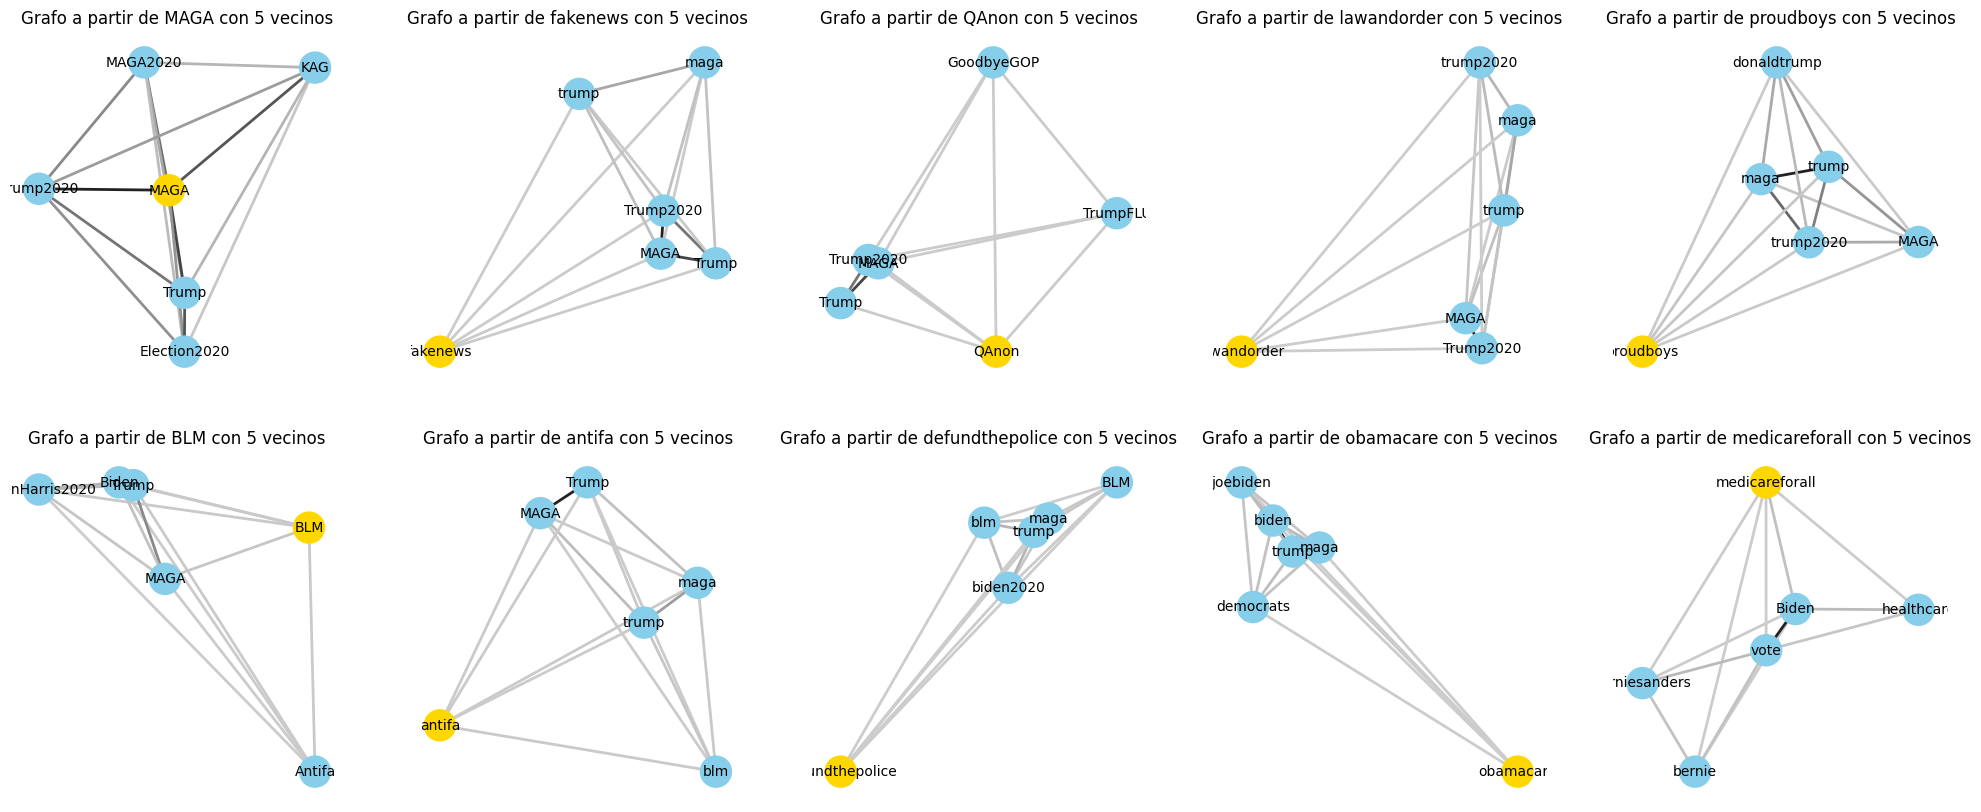

In [90]:
import matplotlib.pyplot as plt

def demo_nodos(G, central_node, number_neighbors):

    # Ordenar vecinos
    neighbors = list(G[central_node].items())
    neighbors_sorted = sorted(neighbors, key=lambda x: float(x[1].get("weight",0)), reverse=True)
    top5_neighbors = [n for n, attr in neighbors_sorted[:number_neighbors]]

    # Crear subgrafo
    sub_nodes = [central_node] + top5_neighbors
    subG = G.subgraph(sub_nodes)

    # Dibujar nodos
    pos = nx.spring_layout(subG, seed=42)
    node_colors = ["gold" if n == central_node else "skyblue" for n in subG.nodes()]
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=500)

    # Colores de las aristas
    min_gray = "#cccccc"  
    max_gray = "#222222"  
    def hex_to_rgb(h):
        h = h.lstrip("#")
        return tuple(int(h[i:i+2],16)/255 for i in (0,2,4))

    rgb_min = hex_to_rgb(min_gray)
    rgb_max = hex_to_rgb(max_gray)

    weights = [float(subG[u][v].get("weight",1)) for u,v in subG.edges()]
    max_weight = max(weights)

    edge_colors = []
    for w in weights:
        t = w / max_weight  
        r = rgb_min[0] + t*(rgb_max[0]-rgb_min[0])
        g = rgb_min[1] + t*(rgb_max[1]-rgb_min[1])
        b = rgb_min[2] + t*(rgb_max[2]-rgb_min[2])
        edge_colors.append((r,g,b))

    # Dibujar aristas
    nx.draw_networkx_edges(subG, pos, width=2, edge_color=edge_colors)

    # Etiquetas
    nx.draw_networkx_labels(subG, pos, font_size=10)

    plt.title(f"Grafo a partir de {central_node} con {number_neighbors} vecinos")
    plt.axis('off')

# Hashtags importantes
hashtags = [
    "MAGA", "fakenews", "QAnon", "lawandorder", "proudboys",
    "BLM", "antifa", "defundthepolice", "obamacare", "medicareforall"
]

fig, axes = plt.subplots(2,5, figsize=(25,10))  

for ax, hashtag in zip(axes.flatten(), hashtags):
    plt.sca(ax) 
    demo_nodos(G, hashtag, 5)  


# Ejercicios

## 1. Calcula las comunidades utilizando el algoritmo de Leiden. ¿Cuántas comunidades salen? 

In [4]:
!pip install cdlib --quiet
!pip install leidenalg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 88.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 58.5 MB/s eta 0:00:00:00:01


En la siguiente celda aplicamos Leiden y sacamos el número de comunidades. Haciendo varias iteraciones obtenemos números distintos, ya que se generan muchas comunidades con pocos nodos (y pocos tweets). Hacemos un loop en el que se aplica Leiden hasta obtener un número adecuado de comunidades. En este ejemplo en concreto obtenemos (COMPLETAR) comunidades.

In [12]:
from cdlib.algorithms import leiden

num_communities=1000
num_iteraciones=0
lowest_num_communities=1000

while num_communities>35 and num_iteraciones<=20: 
    # Restrinjo el número de nodos para que no haya mucho ruido de comunidades con pocos nodos (y no filtrarlos después)
    communities = leiden(G)
    num_communities = len(communities.communities)
    if num_communities<lowest_num_communities:
        lowest_num_communities=num_communities
        communities_save=communities
    num_iteraciones+=1
    print(f"Iteración {num_iteraciones}: {num_communities} comunidades.")

if num_communities>35:
    communities=communities_save
    num_communities=lowest_num_communities

print("Número de comunidades detectadas:", num_communities)


Iteración 1: 46 comunidades.
Iteración 2: 58 comunidades.
Iteración 3: 38 comunidades.
Iteración 4: 40 comunidades.
Iteración 5: 53 comunidades.
Iteración 6: 30 comunidades.
Número de comunidades detectadas: 30


In [13]:
# Asignar comunidad a cada nodo
nx.set_node_attributes(G, None, "community")
for community_id, nodes in enumerate(communities.communities):
    for node in nodes:
        G.nodes[node]["community"] = community_id

Y a continuación mostramos las comunidades resultantes, representadas por sus 6 nodos con mayor weight combinado (mayor número de tweets que incluyen esos hashtags). Podemos ver que se han generado comunidades pequeñas con pocos nodos y consecuentemente pocos tweets (hemos pintado las comunidades con menos de 1000 tweets en gris en la imagen). Vamos a mantenerlos en el análisis de los siguientes apartados para estudiar el grafo original al completo, aunque la información de estas comunidades es prácticamente nula en comparación con los tweets de comunidades con más nodos. 

In [15]:
import pandas as pd
from collections import defaultdict

# Formato de números
def format_number(n):
    if n >= 1_000_000:
        return f"{n/1_000_000:.1f}M"
    elif n >= 1_000:
        return f"{n/1_000:.1f}k"
    else:
        return str(int(n))

# Tweets por nodo
def node_total_weight(G, node):
    return sum(float(attr.get("weight", 0)) for _, _, attr in G.edges(node, data=True))

# Agrupar nodos por comunidad
communities_dict = defaultdict(list)
for node, data in G.nodes(data=True):
    comm = data.get("community")
    if comm is not None:
        communities_dict[comm].append(node)

# Df con info de cada comunidad
community_rows = []

for community_id, nodes in sorted(communities_dict.items()):
    num_nodes = len(nodes)
    node_weights = {node: node_total_weight(G, node) for node in nodes}
    total_tweets = sum(node_weights.values())
    top_10_nodes = sorted(node_weights.items(), key=lambda x: x[1], reverse=True)[:10]
    top_10_node_names = [node for node, _ in top_10_nodes]
    
    community_rows.append({
        "community_id": community_id,
        "num_nodes": num_nodes,
        "total_tweets": int(total_tweets),
        "top_10_nodes": top_10_node_names 
    })

community_df = pd.DataFrame(community_rows)
community_df

,community_id,num_nodes,total_tweets,top_10_nodes
0,0,9811,4825367,"[Trump, Biden, Venezuela, Cuba, Mexico, Hispan..."
1,1,8987,11697304,"[MAGA, Trump2020, MAGA2020, KAG, DonaldTrump, ..."
2,2,6715,7195785,"[trump, maga, vote, biden, trump2020, election..."
3,3,6131,11288735,"[BidenHarris2020, Biden2020, VoteBlue, VOTE, J..."
4,4,5564,4853183,"[Election2020, Elections2020, ElectionDay, Ele..."
5,5,2865,2438497,"[COVID19, coronavirus, COVID, XboxSeriesX, nin..."
6,6,2566,3076561,"[USA, China, US, Obama, Coronavirus, Covid, Co..."
7,7,1367,452546,"[TRUMP, BIDEN, ELECTION2020, STOPTHESTEAL, VOT..."
8,8,1322,852483,"[AI, DataScience, coding, VR, robotics, codene..."
9,9,753,704599,"[Latinos, LGBTQ, GA, Atlanta, GEORGIA, PA, AZ,..."


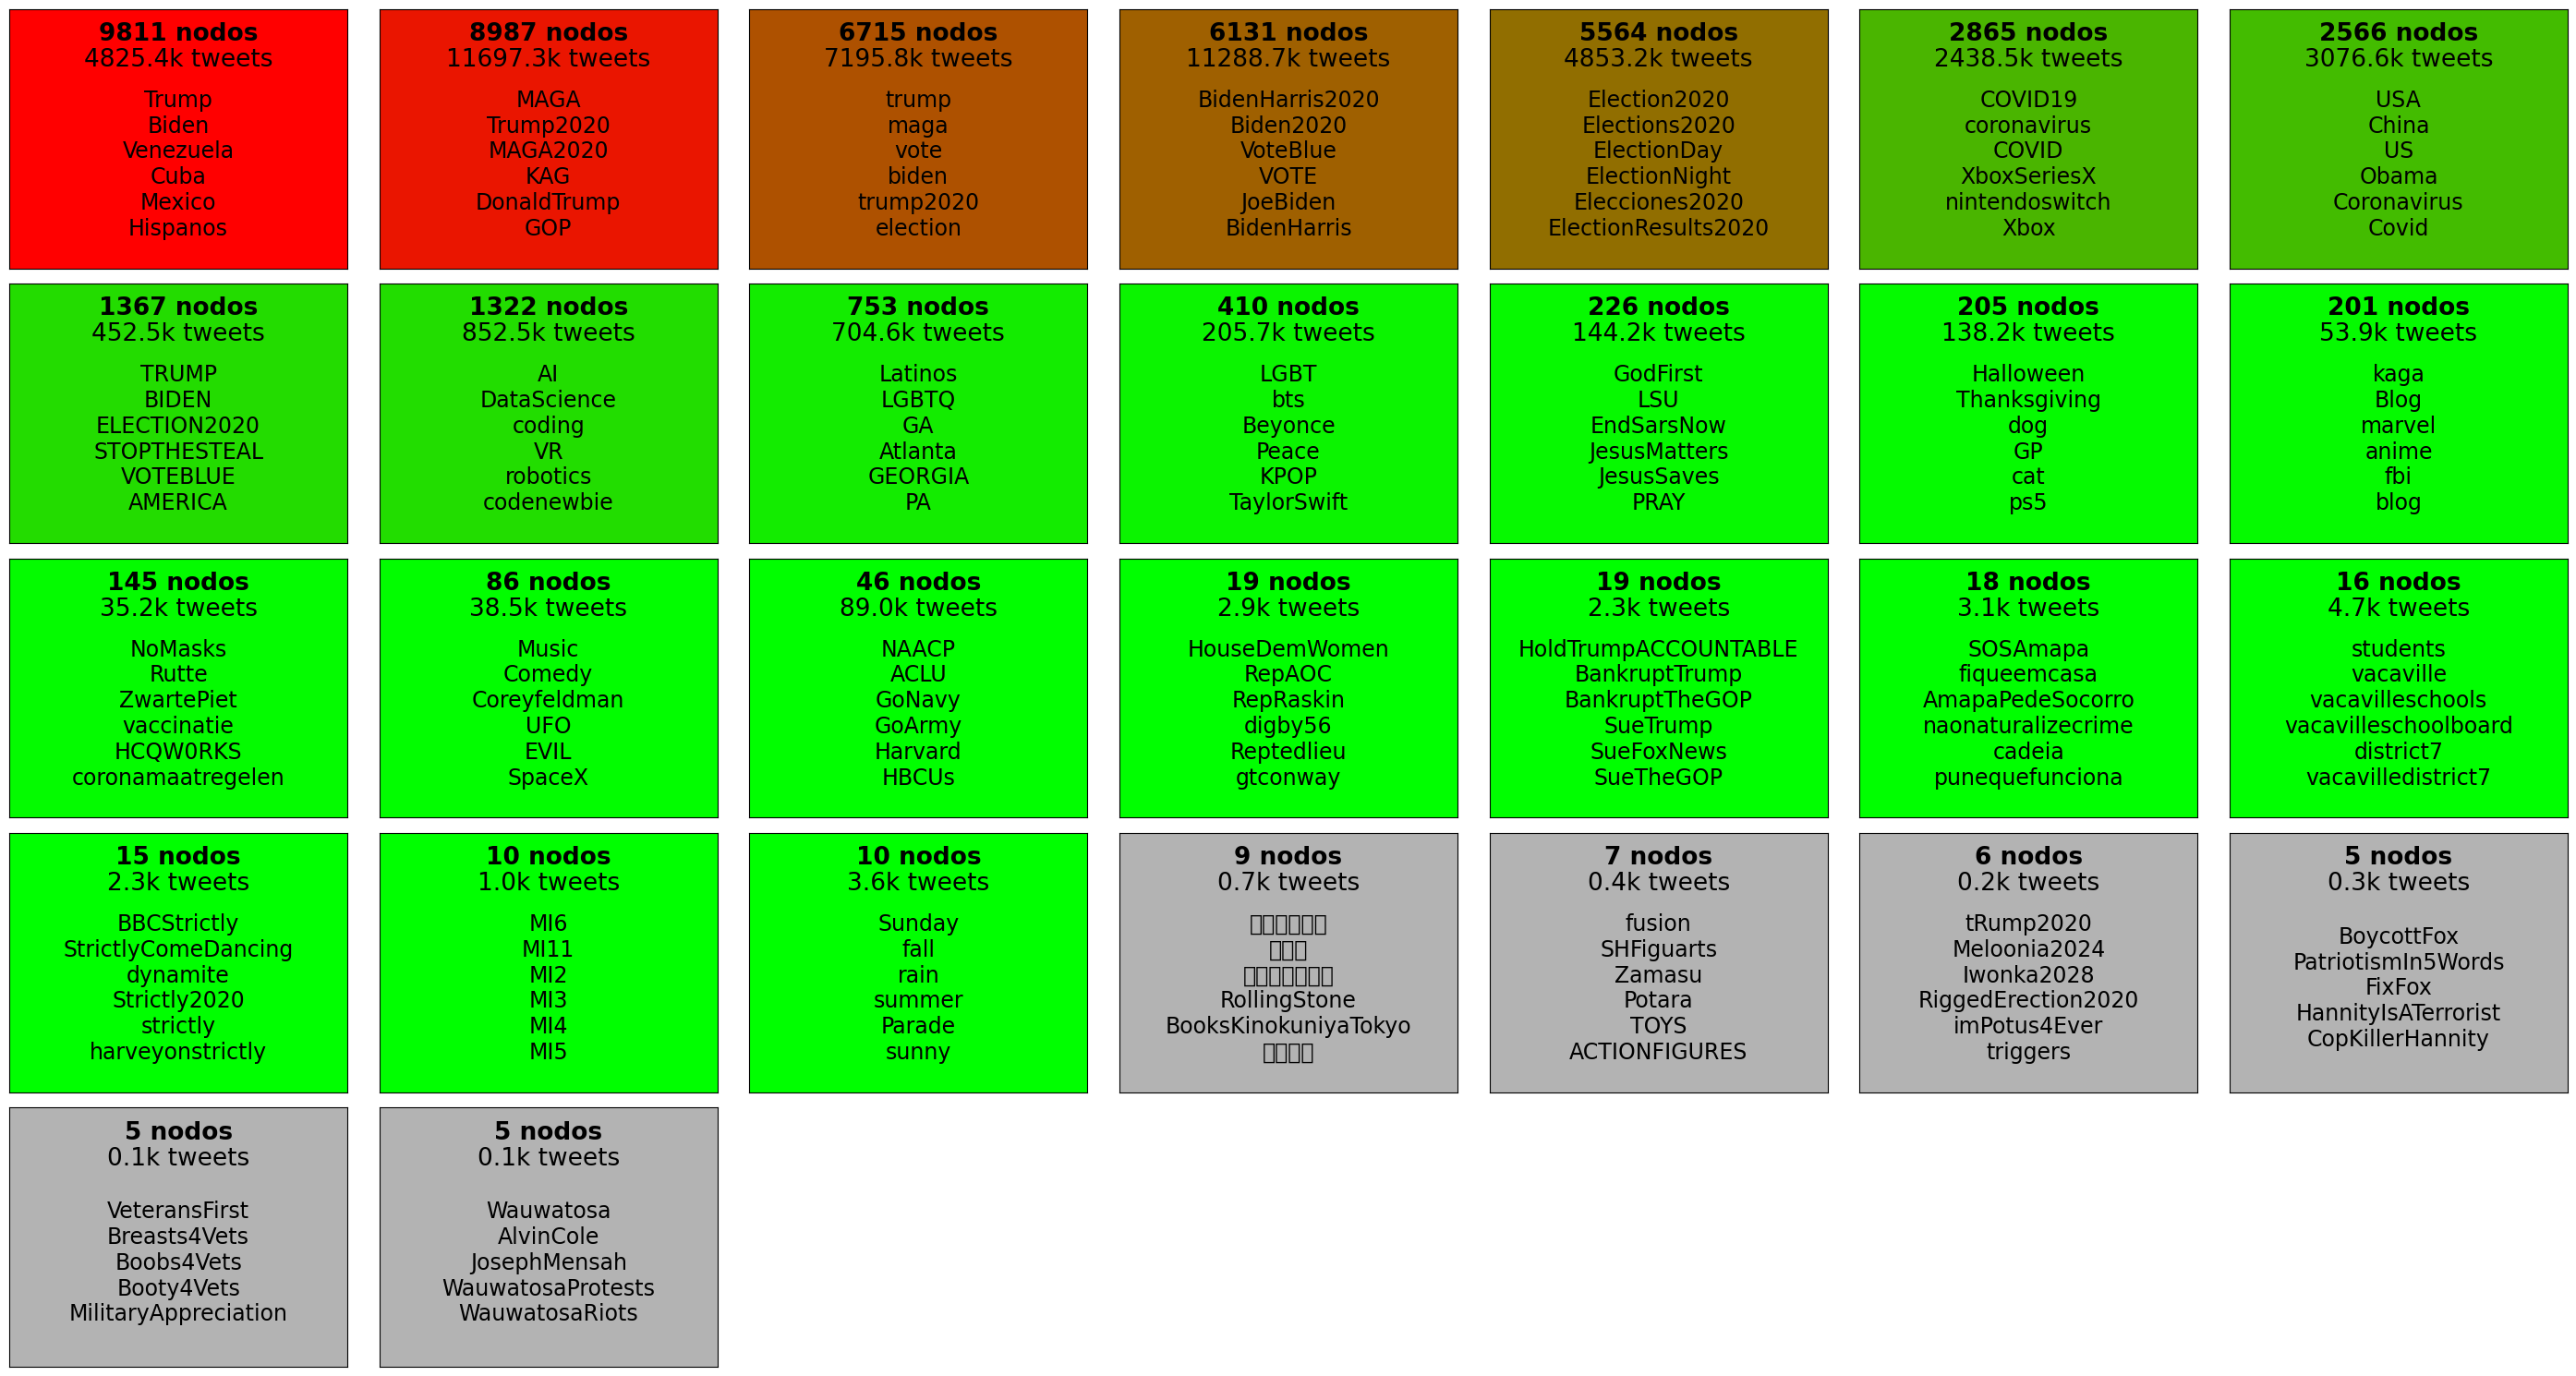

In [18]:
# Función para plotear comunidades
def plot_comunidades_df(df, top_n_nodes=5, minimum_tweets_filter=0, minimum_tweets_color=0):
    filtered_df = df[df["total_tweets"] >= minimum_tweets_filter]

    cols = 7
    rows = int(np.ceil(len(filtered_df) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    if rows == 1:
        axes = np.array([axes])

    # Rangos para colores
    sizes = filtered_df["num_nodes"].tolist()
    min_size, max_size = min(sizes), max(sizes)

    for plot_idx, (_, row) in enumerate(filtered_df.iterrows()):
        row_idx = plot_idx // cols
        col_idx = plot_idx % cols
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]

        # Color según tamaño
        if row["total_tweets"] < minimum_tweets_color:
            color = (0.7, 0.7, 0.7)
        else:
            t = (row["num_nodes"] - min_size) / (max_size - min_size + 1e-6)
            color = (t, 1-t, 0)

        ax.add_patch(plt.Rectangle((0,0),1,1,color=color))

        # Top N nodos
        top_nodes_text = "\n".join(row["top_10_nodes"][:top_n_nodes])
        ax.text(0.5, 0.4, top_nodes_text, ha="center", va="center", fontsize=17)
        ax.text(0.5, 0.95, f"{row['num_nodes']} nodos", ha="center", va="top", fontsize=19, fontweight='bold')

        total_tweets_k = row["total_tweets"] / 1000
        ax.text(0.5, 0.85, f"{total_tweets_k:.1f}k tweets", ha="center", va="top", fontsize=19)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)

    total_slots = rows * cols
    for j in range(len(filtered_df), total_slots):
        row_idx = j // cols
        col_idx = j % cols
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_comunidades_df(community_df, top_n_nodes=6, minimum_tweets_filter=0, minimum_tweets_color=1000)

## 2. Utiliza Weisfeiler-lehmangraph kernels para codificar cada una de las comunidades como si de grafos independientes se trataran. Basado en los resultados obtenidos, ¿qué comunidades son más similares? 


In [19]:
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram

# Subgrafos
subgraphs = [G.subgraph(communities.communities[i]).copy() for i in range(num_communities)]
grakel_graphs = graph_from_networkx(subgraphs, val_node_labels='0')

# Crear el kernel WL
wl = WeisfeilerLehman(n_iter=3, normalize=True, base_graph_kernel=VertexHistogram)
K = wl.fit_transform(grakel_graphs)

# Eliminar diagonal y triangulo inferior
K_no_diag = K.copy()
np.fill_diagonal(K_no_diag, 0)
K_unique = K_no_diag.copy()
K_unique[np.tril_indices_from(K_unique)] = 0

# Obtener los índices de las mayores similitudes
flat_indices = np.argsort(K_unique, axis=None)[-10:]
pairs = np.unravel_index(flat_indices, K_unique.shape)

Como podemos ver en la matriz, conforme el número de las comunidades avanza (las comunidades se hacen más pequeñas, menos nodos) se vuelven menos similares entre si, salvo que tengan el mismo número de nodos, como veremos en el siguiente código. Las primeras comunidades son en general más parecidas entre sí.

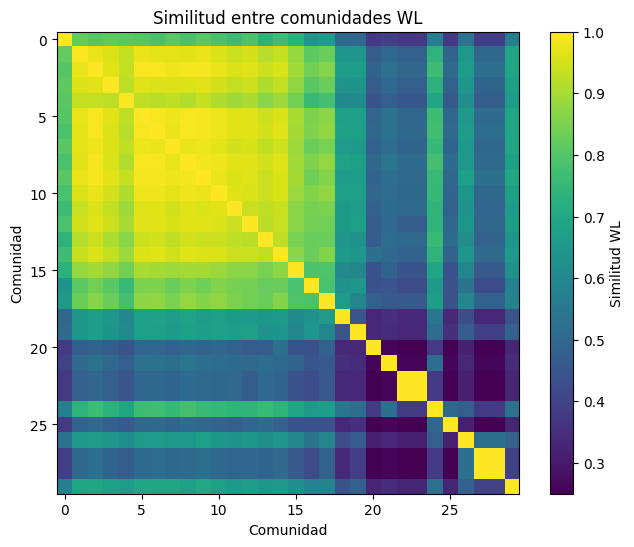

In [20]:
indices = np.unravel_index(
    np.argsort(K_no_diag, axis=None)[-3:],
    K_no_diag.shape
)

similarities = K_no_diag[indices]

# Heatmap de similitud
plt.figure(figsize=(8, 6))
plt.imshow(K, cmap="viridis")
plt.colorbar(label="Similitud WL")
plt.title("Similitud entre comunidades WL")
plt.xlabel("Comunidad")
plt.ylabel("Comunidad")
plt.show()

En el siguiente código, que muestra las 10 parejas con mayor similitud, vemos las parejas de comunidades con similitud 1 (correspondientes a comunidades pequeñas) y las parejas con alta similitud, correspondientes a las comunidades con más nodos, que suelen tener en común que sus hashtags son generales y usados de manera masiva. 

In [21]:
K_temp = K_no_diag.copy()
K_temp[np.tril_indices_from(K_temp)] = 0

# Indices de las 10 mayores similitudes
flat_indices = np.argsort(K_temp, axis=None)[-10:][::-1]
pairs = np.unravel_index(flat_indices, K_temp.shape)

for idx in range(len(flat_indices)):
    i, j = pairs[0][idx], pairs[1][idx]
    simil = K_temp[i, j]
    
    # Información de cada comunidad
    comm_i = community_df.iloc[i]
    comm_j = community_df.iloc[j]
    
    print(f"\nSimilitud: {simil:.4f} entre comunidad {i} y comunidad {j}")
    print(f"Comunidad {i}: {comm_i['num_nodes']} nodos, {int(comm_i['total_tweets'])} tweets -> " +
          ", ".join(comm_i['top_10_nodes'][:10]))
    print(f"Comunidad {j}: {comm_j['num_nodes']} nodos, {int(comm_j['total_tweets'])} tweets -> " +
          ", ".join(comm_j['top_10_nodes'][:10]))
    


Similitud: 1.0000 entre comunidad 22 y comunidad 23
Comunidad 22: 10 nodos, 1006 tweets -> MI6, MI11, MI2, MI3, MI4, MI5, MI7, MI8, MI9, MI10
Comunidad 23: 10 nodos, 3571 tweets -> Sunday, fall, rain, summer, Parade, sunny, gloomy, rainy, remembering, Boat

Similitud: 1.0000 entre comunidad 27 y comunidad 28
Comunidad 27: 5 nodos, 280 tweets -> BoycottFox, PatriotismIn5Words, FixFox, HannityIsATerrorist, CopKillerHannity
Comunidad 28: 5 nodos, 140 tweets -> VeteransFirst, Breasts4Vets, Boobs4Vets, Booty4Vets, MilitaryAppreciation

Similitud: 0.9941 entre comunidad 6 y comunidad 8
Comunidad 6: 2566 nodos, 3076561 tweets -> USA, China, US, Obama, Coronavirus, Covid, Covid19, UK, Israel, News
Comunidad 8: 1322 nodos, 852483 tweets -> AI, DataScience, coding, VR, robotics, codenewbie, maya3ds, facialrecognition, economy, stimulus

Similitud: 0.9936 entre comunidad 5 y comunidad 6
Comunidad 5: 2865 nodos, 2438497 tweets -> COVID19, coronavirus, COVID, XboxSeriesX, nintendoswitch, Xbox, Cov

## 3. El tamaño del grafo excede el tiempo que tenemos en la práctica, por ello, y para tener una representación más compacta, colapsa el grafo de forma que cada nodo sea una comunidad, manteniendo los atributos. 


Colapsamos las comunidades en nodos asignandoles el número de comunidad, el número de nodos y el número de tweets, y calculamos el peso como la suma de los tweets interconectados entre comunidades con los weights individuales de cada nodo que forma parte de ellas. 

In [ ]:
import networkx as nx
from collections import defaultdict

# Agrupar nodos por comunidad 
communities = defaultdict(list)
for n, data in G.nodes(data=True):
    cid = data["community"]
    communities[cid].append(n)

# Construir grafo de comunidades
G_coms = nx.Graph()

# Crear nodos de comunidades con atributos
for cid, nodes in communities.items():
    node_strength = {
        n: sum(float(G[n][nbr].get("weight", 1)) for nbr in G[n])
        for n in nodes
    }

    G_coms.add_node(
        cid, 
        size=len(nodes),
        num_tweets=sum(node_strength.values()),
        top_10_nodes=sorted(
            node_strength,
            key=node_strength.get,
            reverse=True
        )[:10]
    )

# Aristas entre comunidades
edge_weights = defaultdict(float)

for u, v, data in G.edges(data=True):
    cu = G.nodes[u]["community"]
    cv = G.nodes[v]["community"]

    if cu != cv:
        edge_weights[(cu, cv)] += float(data.get("weight", 1))

if edge_weights:
    min_w = min(edge_weights.values())
    max_w = max(edge_weights.values())

    for (cu, cv), w in edge_weights.items():
        w_norm = (w - min_w) / (max_w - min_w + 1e-6)
        G_coms.add_edge(cu, cv, weight=w_norm)


In [23]:
print("Nodos originales:", G.number_of_nodes())
print("Nodos colapsados:", G_coms.number_of_nodes())

Nodos originales: 47544
Nodos colapsados: 30


In [32]:
top_nodes = sorted(G_coms.nodes(data=True), key=lambda x: x[1]["size"], reverse=True)[:3]

for idx, (node_id, attrs) in enumerate(top_nodes):
    print(f"Comunidad {node_id}: {attrs['size']} nodos, {int(attrs['num_tweets'])} tweets")
    print(f"{attrs['top_10_nodes']}")
    print()


Comunidad 0: 9811 nodos, 4825367 tweets
['Trump', 'Biden', 'Venezuela', 'Cuba', 'Mexico', 'Hispanos', 'Latinas', 'Twitter', 'BLMprotest', 'Argentina']

Comunidad 1: 8987 nodos, 11697304 tweets
['MAGA', 'Trump2020', 'MAGA2020', 'KAG', 'DonaldTrump', 'GOP', 'America', 'Democrats', 'AmericaFirst', 'Republicans']

Comunidad 2: 6715 nodos, 7195785 tweets
['trump', 'maga', 'vote', 'biden', 'trump2020', 'election', 'election2020', 'covid', 'covid19', 'usa']



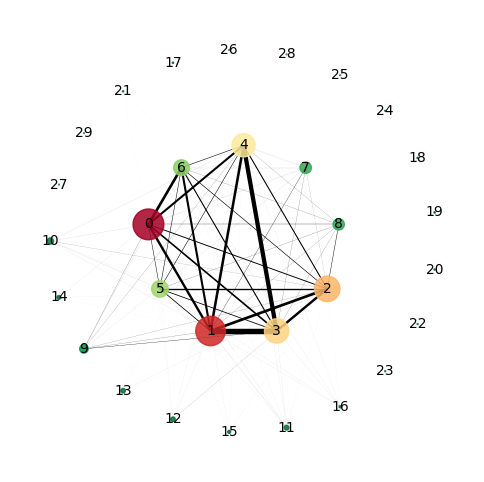

In [57]:
import matplotlib.colors as mcolors

shells = [
    [n for n in G_coms if G_coms.nodes[n]["size"] > 1000],
    [n for n in G_coms if G_coms.nodes[n]["size"] <= 1000]
]
pos = nx.shell_layout(G_coms, shells)


sizes = [G_coms.nodes[n]["size"] for n in G_coms.nodes]
node_sizes = [s / 20 for s in sizes]

norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))
cmap = plt.cm.RdYlGn_r  
node_colors = [cmap(norm(s)) for s in sizes]

edge_widths = [
    G_coms.edges[u, v]["weight"] * 5
    for u, v in G_coms.edges
]

plt.figure(figsize=(6, 6))

nx.draw_networkx_nodes(G_coms, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
nx.draw_networkx_edges(G_coms, pos, width=edge_widths, alpha=1)
nx.draw_networkx_labels(G_coms, pos, labels={n: n for n in G_coms.nodes}, font_size=10)

plt.axis("off")
plt.show()


## 4. Aplica distintas métricas que puedan resultar útiles para tener una mejor idea de las comunidades, y crea visualizaciones diferentes en función de las métricas. 

### Modularidad

In [61]:
import networkx as nx
from networkx.algorithms.community.quality import modularity

for u, v, data in G.edges(data=True):
    data["weight"] = float(data.get("weight", 1))

communities = {}
for n, data in G.nodes(data=True):
    cid = data["community"]
    communities.setdefault(cid, set()).add(n)

partition = list(communities.values())

# Calcular modularidad
Q = modularity(G, partition, weight="weight")

print(f"Modularidad de G: {Q:.4f}")


Modularidad de G: 0.3671


### Top-10 de cada comunidad en el grafo original

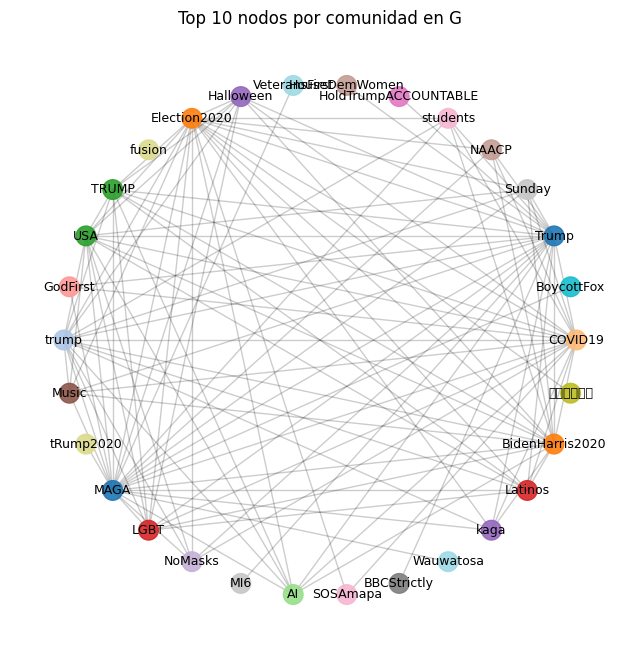

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

top_k = 1

top_nodes = {}
for cid, data in G_coms.nodes(data=True):
    for n in data["top_10_nodes"][:top_k]: 
        top_nodes[n] = cid

# Subgrafo de nodos
H = G.subgraph(top_nodes.keys()).copy()

# Colores por comunidad
import matplotlib.cm as cm
import matplotlib.colors as mcolors

num_communities = len(set(top_nodes.values()))
cmap = cm.get_cmap("tab20", num_communities)
colors = {cid: cmap(i) for i, cid in enumerate(sorted(set(top_nodes.values())))}
node_colors = [colors[top_nodes[n]] for n in H.nodes]

pos = nx.circular_layout(H)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(H, pos, node_size=200, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(H, pos, alpha=0.2)
nx.draw_networkx_labels(H, pos, font_size=9)

plt.axis("off")
plt.show()


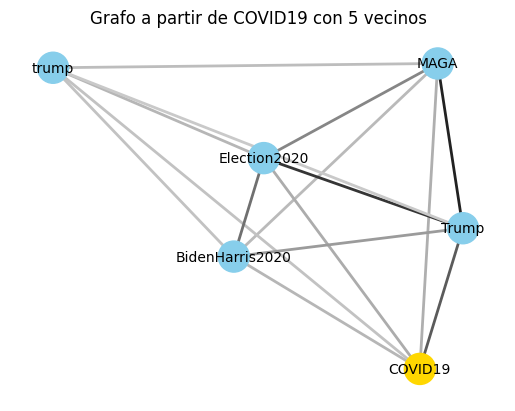

In [ ]:
top_k = 5

top_nodes = {}
for cid, data in G_coms.nodes(data=True):
    for n in data["top_10_nodes"][:top_k]: 
        top_nodes[n] = cid

# Subgrafo de nodos
H = G.subgraph(top_nodes.keys()).copy()


demo_nodos(H, "COVID19", number_neighbors=5)
plt.show()


### Tamaño de las comunidades

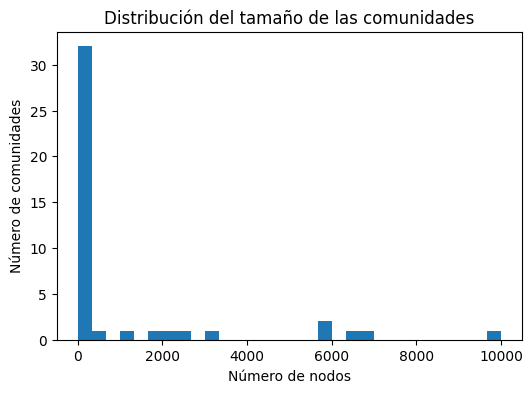

In [ ]:
community_sizes = [len(com) for com in communities.communities]

plt.figure(figsize=(6,4))
plt.hist(community_sizes, bins=30)
plt.xlabel("Número de nodos")
plt.ylabel("Número de comunidades")
plt.title("Distribución del tamaño de las comunidades")
plt.show()


### Peso/tweets por comunidad

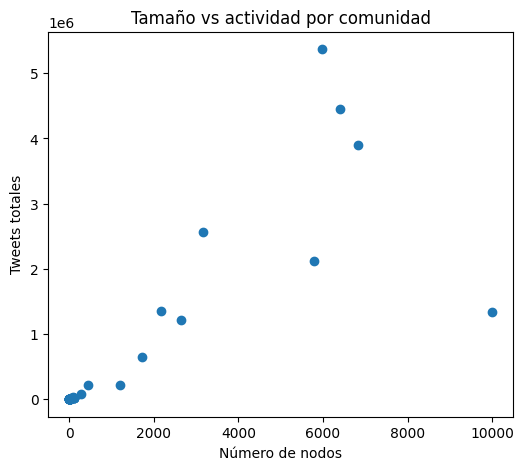

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(community_sizes, community_tweets)
plt.xlabel("Número de nodos")
plt.ylabel("Tweets totales")
plt.title("Tamaño vs actividad por comunidad")
plt.show()


## 5. ¿Hay nodos centrales?, ¿qué métricas nos ayudan a saberlo? ¿Qué métricas macro nos servirían para explicar la estructura de la red, teniendo en cuenta que son comunidades y no nodos? 


## 6. ¿Merece la pena hacer comunidades solapadas o no solapadas?

## 7. ¿Si visualizamos la/s comunidad/es más grandes y las más pequeñas; que se ve, que nos dice esa representación? 

## 8. Describe los contenidos de cada comunidad. ¿Es posible, aunque sea intuitivamente, caracterizar una comunidad en función de sus hashtags más importantes? 


## 9. Finalmente, utilizando técnicas de predicción de aristas, ¿qué comunidades tienen más probabilidades de estar unidas? Habiendo descrito dichas comunidades previamente, ¿tienen sentido estas predicciones? 
